In [1]:
import data_importer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_shape = (416, 416, 3)

D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


float32 uint8 (2, 416, 416, 3) (2, 416, 416, 1)


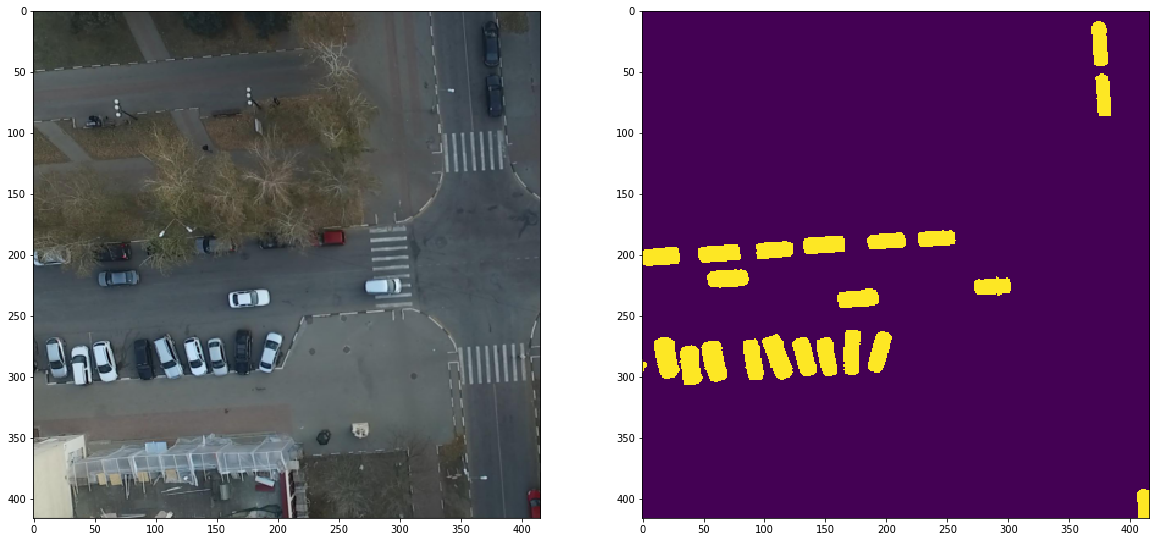

In [3]:
batch_size = 2
CrossRoad_train = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='train',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0.7, 0.1))
CrossRoad_validation = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='validation',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0.7, 0.1))
CrossRoad_test = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='test',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0.7, 0.1))

preview = iter(CrossRoad_train)
a,b=next(preview)
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(np.float32(a[0]))
plt.subplot(1,2,2)
plt.imshow(b[0,:,:,0])
plt.viridis()

print(a.dtype, b.dtype, a.shape, b.shape)

In [4]:
tf.keras.backend.set_floatx('float32')

In [5]:
layers = tf.keras.layers
losses = tf.keras.losses

In [6]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [7]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

# outputs = layers.Conv2D(22, (1, 1), activation='softmax')(decoder0)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [8]:
model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [9]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [10]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [11]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [12]:
# model=tf.keras.utils.multi_gpu_model(model, gpus=2)

In [13]:
# model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy"])

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [14]:
save_model_path = './log/3/'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(save_model_path + "my_keras_model.h5"),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='bce_dice_loss', min_delta=0.001),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir=save_model_path)
]

In [ ]:
history = model.fit_generator(CrossRoad_train, 
                   steps_per_epoch=preview.dataset.shape[0] - 1,
                   epochs=10,
                   callbacks=callbacks)

# model.fit_generator(SYNTHIA_train, steps_per_epoch=train_step, epochs=30, callbacks=callbacks, 
#                     validation_data=SYNTHIA_validation, validation_steps=validation_steps)

Epoch 1/10
499/499 [==============================] - 437s 875ms/step - loss: 0.9902 - dice_loss: 0.4360
Epoch 2/10
169/499 [=========>....................] - ETA: 4:44 - loss: 0.1578 - dice_loss: 0.0733

In [17]:
# model = tf.keras.models.load_model('C:/Users/mamin/GitHub/RAAI-CDS-Hackathon/log/1/weights.hdf5')

In [18]:
a,b=next(preview)
model.evaluate(a,b)

1/1 [==============================] - 1s 1s/step


[0.021535154432058334, 0.021535154432058334]

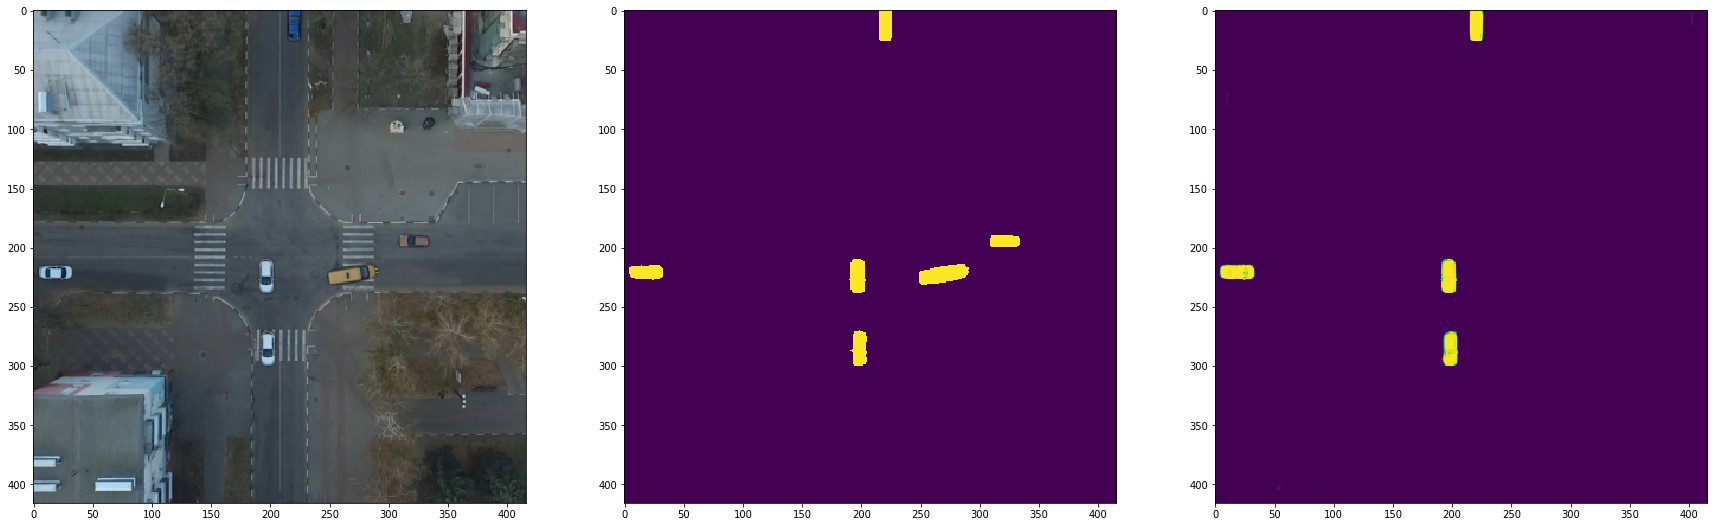

In [35]:
a,b=next(preview)
c=model.predict(a,steps=1)

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(b[0,:,:,0])
plt.subplot(1,3,3)
plt.imshow(c[0,:,:,1])

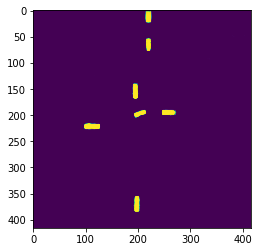

In [51]:
plt.imshow(c[0,:,:,1])